<a href="https://colab.research.google.com/github/Kraykray69/Road_traffic_video_monitoring-using-YOLO/blob/main/Traffic_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

!kaggle datasets download -d shawon10/road-traffic-video-monitoring

!unzip road-traffic-video-monitoring.zip

Dataset URL: https://www.kaggle.com/datasets/shawon10/road-traffic-video-monitoring
License(s): unknown
 97% 45.0M/46.4M [00:02<00:00, 28.9MB/s]
100% 46.4M/46.4M [00:02<00:00, 20.0MB/s]
Archive:  road-traffic-video-monitoring.zip
  inflating: british_highway_traffic.mp4  
  inflating: dhaka_traffic.mp4       
  inflating: road_trafifc.mp4        
  inflating: traffic_detection.mp4   
  inflating: traffic_video.avi       


In [3]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 26.2 MB/s eta 0:00:00


In [17]:
import cv2
from ultralytics import YOLO

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

import IPython
from IPython.display import Video, display
%matplotlib inline

In [22]:
path = '/content/british_highway_traffic.mp4'

In [23]:
# Displaying the target video
frac = 0.65
display(Video(data=path, height=int(720*frac), width=int(1280*frac)))

In [24]:
#loading a YOLO model
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

In [25]:
dict_classes

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [26]:
model.info(detailed=True)

layer                                     name  gradient   parameters                shape         mu      sigma
    0                      model.0.conv.weight     False         2160        [80, 3, 3, 3]  -0.000886     0.0835 torch.float32
    1                        model.0.bn.weight     False           80                 [80]       2.84       1.18 torch.float32
    2                          model.0.bn.bias     False           80                 [80]      0.131       1.58 torch.float32
    3                      model.1.conv.weight     False       115200      [160, 80, 3, 3]  -0.000435     0.0142 torch.float32
    4                        model.1.bn.weight     False          160                [160]       2.56      0.554 torch.float32
    5                          model.1.bn.bias     False          160                [160]      0.264       1.16 torch.float32
    6                  model.2.cv1.conv.weight     False        25600     [160, 160, 1, 1]   -0.00238     0.0221 torch.float3

(365, 68229648, 0, 258.5472512)

In [27]:
def resize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    if frame is None:
        return frame
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

In [30]:
### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 100

In [31]:
# Reading video with cv2
video = cv2.VideoCapture(path)

# Objects to detect Yolo
class_IDS = [2, 3, 5, 7]
# Auxiliary variables
centers_old = {}
centers_new = {}
obj_id = 0
#Vehicles count
veiculos_contador_in = dict.fromkeys(class_IDS, 0)
veiculos_contador_out = dict.fromkeys(class_IDS, 0)
end = []
frames_list = []
#Line which determines the vehicles coming in or out
cy_linha = int(1500 * scale_percent/100 )
cx_sentido = int(2000 * scale_percent/100)
offset = int(8 * scale_percent/100 )
#Initializing count of vehicles
contador_in = 0
contador_out = 0
print(f'[INFO] - Verbose during Prediction: {verbose}')


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (1364, 768)


In [32]:
# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Original Dim:  (1364, 768)


In [33]:
#-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path,
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                               fps, (width, height))


In [34]:
video.get(cv2.CAP_PROP_FRAME_COUNT)

1549.0

In [35]:
#-------------------------------------------------------
# Executing Recognition
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1)):

    # reading frame from video
    _, frame = video.read()

    #Applying resizing of read frame

    frame  = resize_frame(frame, scale_percent)

    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))

    # Getting predictions
    y_hat = model.predict(frame, conf = 0.7, classes = class_IDS, device = 'cpu', verbose = False)

    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy()

    # Storing the above information in a dataframe
    positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.data, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])

    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]

    # Drawing transition line for in\out vehicles counting
    cv2.line(frame, (0, cy_linha), (int(4500 * scale_percent/100 ), cy_linha), (255,255,0),8)

    # For each vehicles, draw the bounding-box and counting each one the pass thought the transition line (in\out)
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')

        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)

        # drawing center and bounding-box of vehicle in the given frame
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 5) # box
        cv2.circle(frame, (center_x,center_y), 5,(255,0,0),-1) # center of box

        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=frame, text=labels[ix]+' - '+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=2)

        # Checking if the center of recognized vehicle is in the area given by the transition line + offset and transition line - offset
        if (center_y < (cy_linha + offset)) and (center_y > (cy_linha - offset)):
            if  (center_x >= 0) and (center_x <=cx_sentido):
                contador_in +=1
                veiculos_contador_in[category] += 1
            else:
                contador_out += 1
                veiculos_contador_out[category] += 1

    #updating the counting type of vehicle
    contador_in_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_in.items()]
    contador_out_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_out.items()]

    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text='N. vehicles In',
                org= (30,30), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                fontScale=1, color=(255, 255, 0),thickness=1)

    cv2.putText(img=frame, text='N. vehicles Out',
                org= (int(2800 * scale_percent/100 ),30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=1)

    #drawing the counting of type of vehicles in the corners of frame
    xt = 40
    for txt in range(len(contador_in_plt)):
        xt +=30
        cv2.putText(img=frame, text=contador_in_plt[txt],
                    org= (30,xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=1, color=(255, 255, 0),thickness=1)

        cv2.putText(img=frame, text=contador_out_plt[txt],
                    org= (int(2800 * scale_percent/100 ),xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                    fontScale=1, color=(255, 255, 0),thickness=1)

    #drawing the number of vehicles in\out
    cv2.putText(img=frame, text=f'In:{contador_in}',
                org= (int(1820 * scale_percent/100 ),cy_linha+60),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    cv2.putText(img=frame, text=f'Out:{contador_out}',
                org= (int(1800 * scale_percent/100 ),cy_linha-40),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)

    if verbose:
        print(contador_in, contador_out)
    #Saving frames in a list
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)

#Releasing the video
output_video.release()

  0%|          | 0/1548 [00:00<?, ?it/s]

In [36]:
####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)

subprocess.run(
    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])
os.remove(tmp_output_path)

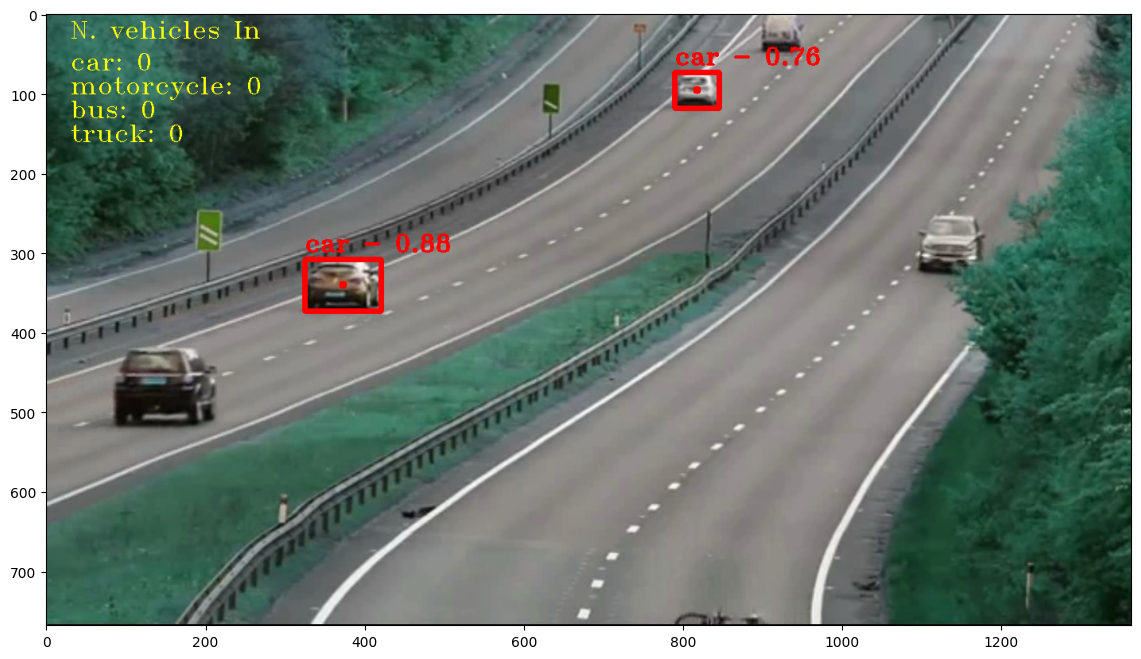

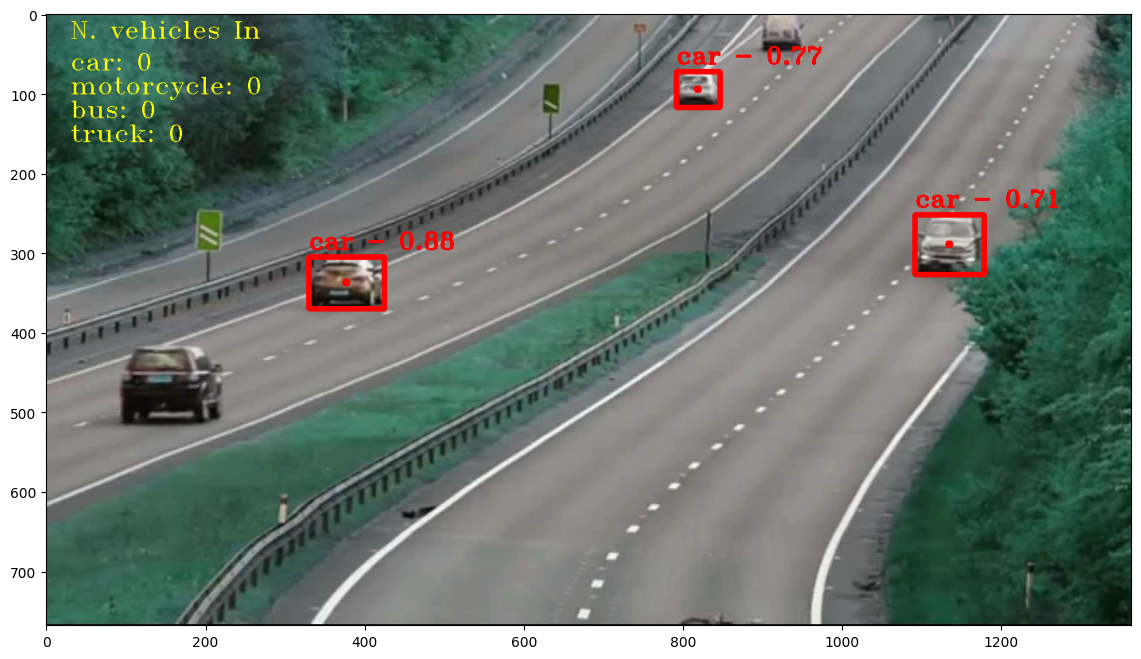

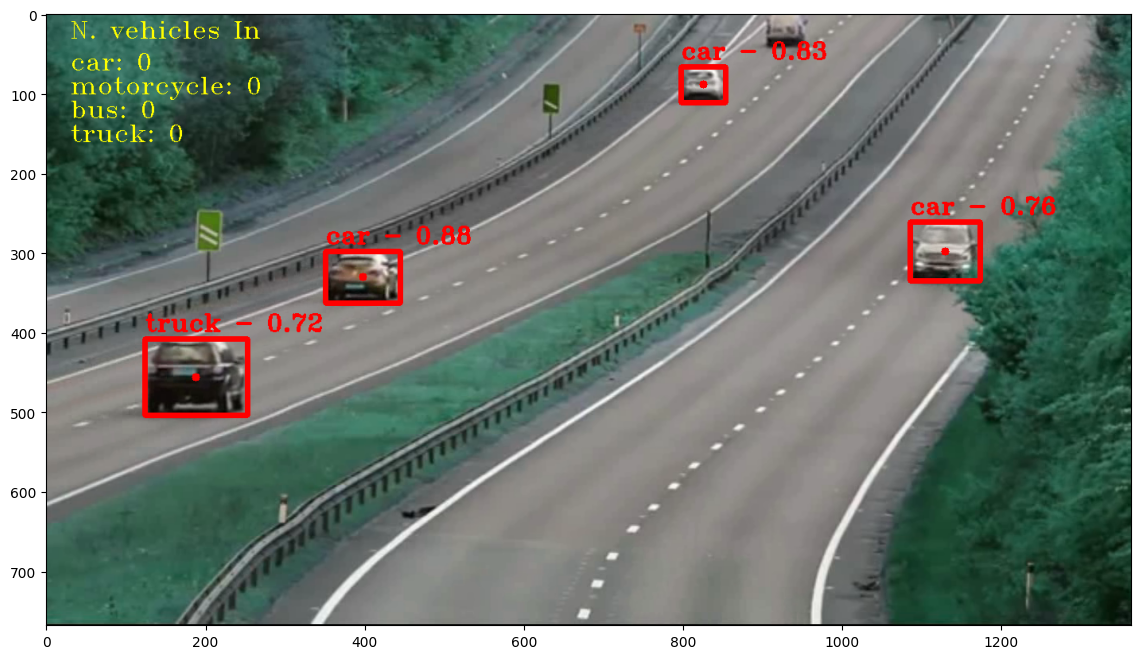

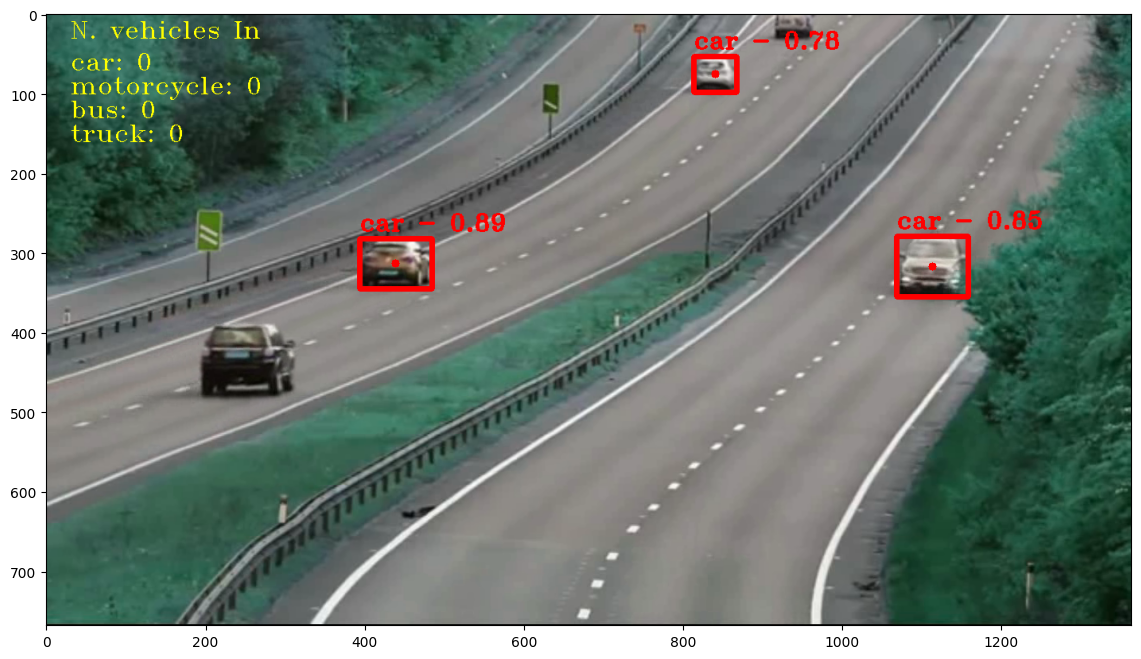

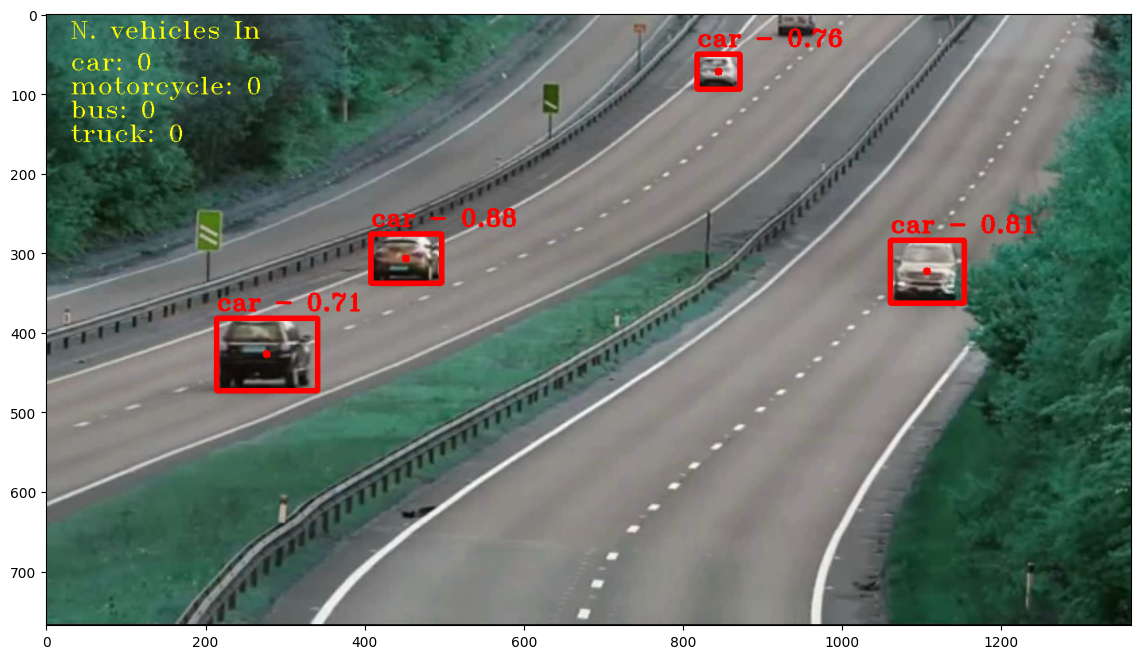

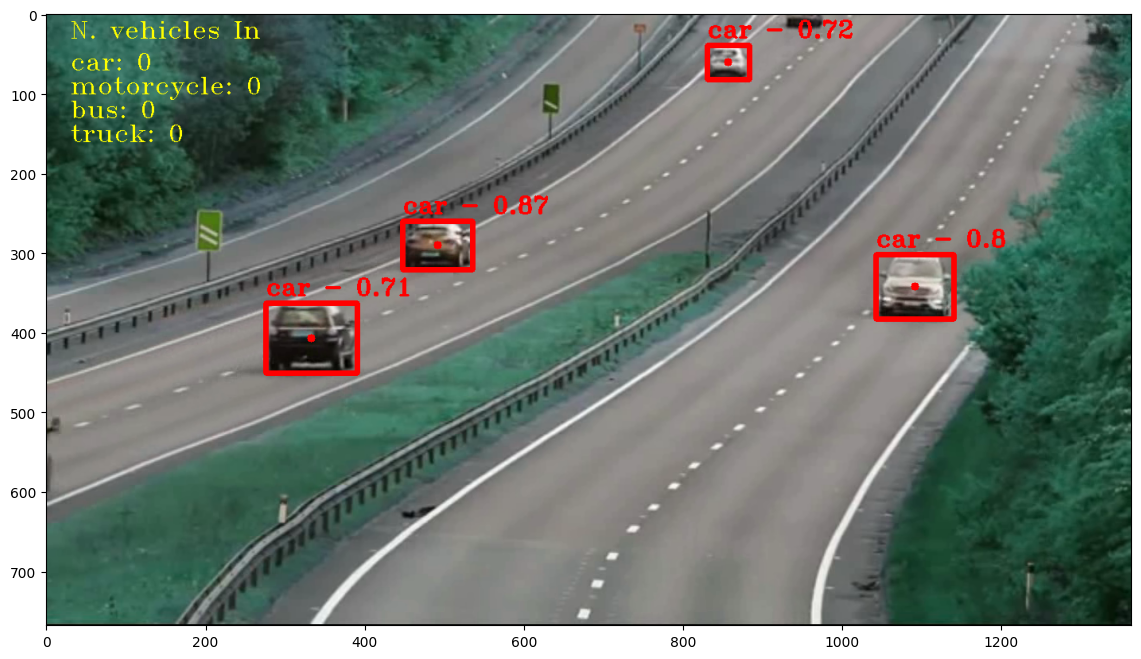

In [37]:
# Checking samples of processed frames
for i in [28, 29, 32, 40, 42, 50]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

In [3]:
#output video result
frac = 0.7
Video(data='rep_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))

"frac = 0.7\nVideo(data='rep_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))"